# Earthquake co-seismic interferogram viewer

In this notebook, we will demonstrate access and visualization of co-seismic interferograms from the live Sentinel-1 InSAR product stream. This notebook demonstrates the use of phase layer of the sentinel-1 interferogram product.

Phase change in a single interferogram is most prominent in interferograms spanning large deformation events like 
   - Earthquakes
   - Glaciers
   - Volcanic eruptions
   
We will use the USGS earthquake catalog to locate events within our interferogram product in this example notebook

## 0. Standard imports for the notebook

In [1]:
import datetime
import json
import numpy as np
import pandas as pd
import requests
from shapely.geometry import Polygon

from earthdaily.earthone.catalog import Product, Image, properties as p
import earthdaily.earthone.dynamic_compute as dc

In [2]:
# Plotting imports and settings
import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline

matplotlib.rcParams['figure.figsize'] = [12, 10]

## 1. Simple utilities for data search

### 1.1 Get Earthquake info from USGS catalog

Simple method to get earthquake information from the USGS catalog.

In [3]:
def get_earthquake_info(eventid):
    """
    Get the geojson from USGS using eventid
    """
    url = f"https://earthquake.usgs.gov/fdsnws/event/1/query?eventid={eventid}&format=geojson"
    r = requests.get(url)
    data = r.json()
    return data

### 1.2 Earthquake to AOI

Simple method to convert the earthquake information to a aoi.

In [4]:
def earthquake_aoi(data):
    """
    Use the depth as a proxy - this can definitely be improved
    """
    
    lon, lat, hgt = data
    lon_scale = 100 / np.cos(np.radians(lat))
    poly = Polygon([[lon - hgt/lon_scale, lat + hgt/100],
                    [lon + hgt/lon_scale, lat + hgt/100],
                    [lon + hgt/lon_scale, lat - hgt/100],
                    [lon - hgt/lon_scale, lat - hgt/100],
                    [lon - hgt/lon_scale, lat + hgt/100]])
    return poly

### 1.3 List available interferograms

In [5]:
def find_interferograms(aoi, timestamp,
                        product="esa:sentinel-1:ifg:v1"):
    """
    Find co-seismic interferograms and group by track + duration
    """
    t0 = timestamp - datetime.timedelta(days=24.01)
    t1 = timestamp + datetime.timedelta(days=24.01)
    
    srch = Product.get(product).images().filter(
        t0 < p.acquired < t1
    ).intersects(aoi)
      
    # Create data frame
    data = []
    
    for img in srch:
        parts = img.id.split(":")[-1].split("-")
        
        # Standardized naming convention
        if len(parts[0]) == 4:
            acq = img.acquired
            post = acq
            pre = acq - datetime.timedelta(days=img.extra_properties["temp_baseline"])
            
            if (pre > timestamp) or (post < timestamp):
                continue
                
            data.append(
                {"id": img.id,
                 "date1": pre.strftime("%Y%m%d"),
                 "date2": post.strftime("%Y%m%d"),
                 "track": parts[4],
                 "days": img.extra_properties["temp_baseline"],
                 "start": img.acquired})
                       
        else:
            raise ValueError("Unknown image type: " + img.id)

    df = pd.DataFrame(data)
    sets = df.groupby(["track", "days", "date1", "date2"])
    return sets, data

### 1.4 Shortest temporal baseline

In [6]:
def select_shortest_pairs(groups, data):
    """
    Results of pandas groupby is used to determine shortest pair
    """
    
    results = {}
    for row, ind in groups.items():
        if row[0] not in results:
            tstart = []
            inds = ind.tolist()
            for idx in inds:
                tstart.append(data[idx]["start"])
            
            pair = {"track": row[0],
                    "days": row[1],
                    "day1": row[2],
                    "day2": row[3],
                    "start": min(tstart),
                    "geom": data[idx]["id"].split("-")[-1]}
            results[row[0]] = pair
            
    return results

### 1.5 Image collection from group

In [7]:
def ifg_collection(pair,
                   product="esa:sentinel-1:ifg:v1",
                   padding=10):
    """
    Set up insar collection for visualization
    """
    
    start = pair["start"]
    padding = datetime.timedelta(seconds=padding)

    prod = Product.get(product)
    images = prod.images().filter(
        p.acquired > (start-padding)).filter(
        p.acquired < (start + padding))
    
    images = dc.ImageStack.from_product_bands(
        product, ["coherence", "phase"],
        start - padding, start + padding
    )
    
    def filter_pair(x):
        return (x.provider_id.split("-")[0].startswith(pair["track"]) and\
               (x.extra_properties["temp_baseline"] == pair["days"]))
                
    # print("Candidates: ", images.count())
    images = images.filter(filter_pair)

    return images

## 2. Example: Southern Qinghai EQ - May 21, 2021

Detailed information related to this earthquake can be found here: 
https://earthquake.usgs.gov/earthquakes/eventpage/us7000e54r/executive

In [8]:
# Gather information about the earthquake
# eq_id = "us6000d3zh"  # Petrinja EQ, Croatia
# eq_id = "us6000d7ix"  # Kurt EQ, Mongolia
# eq_id = "us6000ddge"  # Lethem EQ, Guyana
# eq_id = "us6000e2k3"  # Bendar-e-Genaveh EQ, Iran
# eq_id = "us7000e54r"  # Southern Qinghai EQ, China
# eq_id = "us6000f65h"   # Haiti EQ
eq_id = "us7000g9zq"   # China butterfly
# eq_id = "us7000fes8"   # Greece small
# eq_id = "tx2022yplg"     # Range Hill, Texas
eq_data = get_earthquake_info(eq_id)
eq_coords = eq_data["geometry"]["coordinates"]
eq_aoi = earthquake_aoi(eq_coords)
eq_time = datetime.datetime.fromtimestamp(eq_data["properties"]["time"]/1000,
                                         datetime.timezone.utc)

In [9]:
# Perform search and group by track
coseismic_ifgs, ifg_data = find_interferograms(eq_aoi, eq_time)

In [10]:
# find shortest pairs in each track
shortest_pairs = select_shortest_pairs(coseismic_ifgs.groups, ifg_data)

In [11]:
# Summarize shortest pairs
for k,v in shortest_pairs.items():
    print(f'Track: {v["track"]}, Days: {v["days"]}, Dates: {v["day1"]}-{v["day2"]}')

Track: 026, Days: 12, Dates: 20211229-20220110
Track: 033, Days: 12, Dates: 20211229-20220110
Track: 128, Days: 12, Dates: 20220105-20220117


In [12]:
shortest_pairs

{'026': {'track': '026',
  'days': 12,
  'day1': '20211229',
  'day2': '20220110',
  'start': datetime.datetime(2022, 1, 10, 11, 19, 20, 15814, tzinfo=datetime.timezone.utc),
  'geom': '12'},
 '033': {'track': '033',
  'days': 12,
  'day1': '20211229',
  'day2': '20220110',
  'start': datetime.datetime(2022, 1, 10, 23, 19, 30, 90841, tzinfo=datetime.timezone.utc),
  'geom': '12'},
 '128': {'track': '128',
  'days': 12,
  'day1': '20220105',
  'day2': '20220117',
  'start': datetime.datetime(2022, 1, 17, 11, 11, 10, 486076, tzinfo=datetime.timezone.utc),
  'geom': '12'}}

In [13]:
# setup map
m = dc.map

# Center the map around the earthquake
m.center = (eq_coords[1], eq_coords[0])
m.zoom = 13

In [14]:
# show map
m


`ipyleaflet` and/or `ipywidgets` Jupyter extensions are not installed! (or you're not in a Jupyter notebook.)
To install for JupyterLab, run this in a cell:
    !jupyter labextension install jupyter-leaflet @jupyter-widgets/jupyterlab-manager
To install for plain Jupyter Notebook, run this in a cell:
    !jupyter nbextension enable --py --sys-prefix ipyleaflet
Then, restart the kernel and refresh the webpage.


In [15]:
## Visualize the pairs
pairs = {}
for track, pair in shortest_pairs.items():
    namebase = "-"+pair["track"]+"-"+pair["geom"]
    coll = ifg_collection(pair, padding=30)
    mosaic = coll.mean(axis="images")
    mosaic.pick_bands("coherence").visualize(
        "coh"+namebase, m, scales=(0,1), colormap="gray")
    mosaic.pick_bands("phase").visualize(
        "phase"+namebase, m, scales=(-3.15,3.15), colormap="hsv")
    pairs[track] = mosaic

### 2.1 Download imagery and post process

In [16]:
ctx = dc.map.geocontext(resolution=40, crs="UTM")
ctx.raster_params

{'cutline': None,
 'resolution': 40,
 'srs': '+proj=utm +zone=47 +datum=WGS84 +units=m +no_defs ',
 'bounds_srs': 'EPSG:4326',
 'align_pixels': False,
 'bounds': (100.96435546875,
  37.67077737288316,
  101.65374755859376,
  37.88786039168385),
 'dimensions': None}

In [17]:
# Pull down the data
track = "033"
corr = pairs[track].pick_bands('coherence').compute(ctx)
phase = pairs[track].pick_bands('phase').compute(ctx)

Text(0.5, 0, 'Raw coherence')

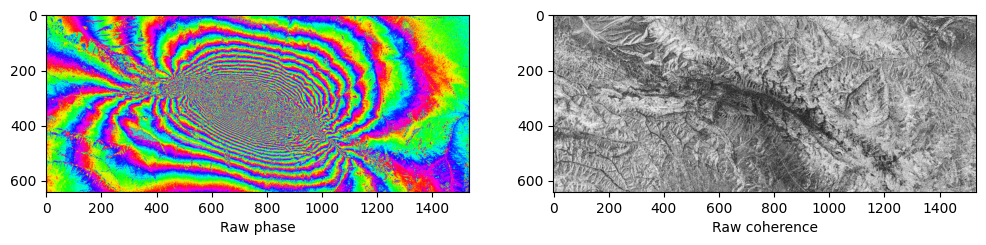

In [18]:
plt.figure()
ax1 = plt.subplot(121)
ax1.imshow(phase["ndarray"][0], cmap="hsv", interpolation=None)
ax1.set_xlabel("Raw phase")
ax2 = plt.subplot(122)
ax2.imshow(corr["ndarray"][0], cmap="gray", interpolation=None)
ax2.set_xlabel("Raw coherence")

In [ ]:
# Plotting and saving
extent = [ctx.bounds[0], ctx.bounds[2], ctx.bounds[1], ctx.bounds[3]]
plt.figure()
plt.imshow(phase["ndarray"][0], extent=extent, vmin=-np.pi, vmax=np.pi, cmap="hsv", interpolation=None, aspect="auto")
#plt.tick_params(top=False, bottom=False, left=False, right=False,
#                labelleft=False, labelbottom=False)
plt.tick_params(labelsize=14)
plt.savefig(f'{eq_id}.png', dpi=300)
# plt.savefig(prefix.split("_")[0] + ".png", dpi=300)